# Importing Necessary Libraries

In [1]:
import regex as re
import numpy as np
import pandas as pd
import spacy
import nltk
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess

# Loading, Cleaning, and Tokenizing the data

In [2]:
df = pd.read_csv('RestaurantReviews.csv')
df = df.dropna()
df

,Restaurant,Review,No_Of_Raters,Time,Cost,American,Asian,French,Indian,Mediterranean
0,Beyond Flavours,"The ambience was good, food was quite good . h...",5,5/25/19 15:54,800,0,1,0,0,0
1,Beyond Flavours,Ambience is too good for a pleasant evening. S...,5,5/25/19 14:20,800,0,1,0,0,0
2,Beyond Flavours,A must try.. great food great ambience. Thnx f...,5,5/24/19 22:54,800,0,1,0,0,0
3,Beyond Flavours,Soumen das and Arun was a great guy. Only beca...,5,5/24/19 22:11,800,0,1,0,0,0
4,Beyond Flavours,Food is good.we ordered Kodi drumsticks and ba...,5,5/24/19 21:37,800,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...
9956,Chinese Pavilion,Madhumathi Mahajan Well to start with nice cou...,3,6/5/16 0:08,"1,000",0,1,0,0,0
9957,Chinese Pavilion,This place has never disappointed us.. The foo...,5,6/4/16 22:01,"1,000",0,0,0,1,0
9958,Chinese Pavilion,"Bad rating is mainly because of ""Chicken Bone ...",2,6/3/16 10:37,"1,000",0,0,0,1,0
9959,Chinese Pavilion,I personally love and prefer Chinese Food. Had...,4,5/31/16 17:22,"1,000",0,1,0,0,0


In [3]:
reviews = df['Review'].tolist()
reviews = [re.sub('\s+', ' ', thing) for thing in reviews]
reviews = [re.sub("\'", "", thing) for thing in reviews]
print(reviews[0])

The ambience was good, food was quite good . had Saturday lunch , which was cost effective . Good place for a sate brunch. One can also chill with friends and or parents. Waiter Soumen Das was really courteous and helpful.


In [4]:
def tokenizer(review):
    for word in review:
        yield(gensim.utils.simple_preprocess(str(word), deacc=True))
        
tokensets = list(tokenizer(reviews))

print(tokensets[0])

['the', 'ambience', 'was', 'good', 'food', 'was', 'quite', 'good', 'had', 'saturday', 'lunch', 'which', 'was', 'cost', 'effective', 'good', 'place', 'for', 'sate', 'brunch', 'one', 'can', 'also', 'chill', 'with', 'friends', 'and', 'or', 'parents', 'waiter', 'soumen', 'das', 'was', 'really', 'courteous', 'and', 'helpful']


# Creating Bigrams, Removing Stopwords, and Lemmatizing

In [5]:
bigram = gensim.models.Phrases(tokensets, min_count=5, threshold=100)
bigram_mod = gensim.models.phrases.Phraser(bigram)
print(bigram_mod[tokensets[0]])

['the', 'ambience', 'was', 'good', 'food', 'was', 'quite', 'good', 'had', 'saturday', 'lunch', 'which', 'was', 'cost_effective', 'good', 'place', 'for', 'sate', 'brunch', 'one', 'can', 'also', 'chill', 'with', 'friends', 'and', 'or', 'parents', 'waiter', 'soumen_das', 'was', 'really', 'courteous', 'and', 'helpful']


In [6]:
def stopword_remover(tokensets):
    return [[token for token in simple_preprocess(str(tokenset)) if token not in stop_words] for tokenset in tokensets]

def bigram_maker(tokensets):
    return [bigram_mod[tokenset] for tokenset in tokensets]

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
def lemmatizer(tokensets, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    better_tokensets = []
    for tokens in tokensets:
        tokenset = nlp(" ".join(tokens)) 
        better_tokensets.append([token.lemma_ for token in tokenset if token.pos_ in allowed_postags])
    return better_tokensets

In [7]:
NoStop = stopword_remover(tokensets)

BiGram = bigram_maker(NoStop)

best_tokensets = lemmatizer(BiGram, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(best_tokensets[0])

['ambience', 'good', 'food', 'quite', 'good', 'saturday', 'lunch', 'cost_effective', 'good', 'place', 'sate', 'brunch', 'also', 'chill', 'friend', 'parent', 'waiter', 'soumen_da', 'really', 'courteous', 'helpful']


# Using LDA to develop a topic model

In [8]:
tokenDict = corpora.Dictionary(best_tokensets)
corpus = [tokenDict.doc2bow(tokenset) for tokenset in best_tokensets]
print(corpus[0])

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 3), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1)]


In [9]:
LDA = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                      id2word=tokenDict,
                                      num_topics=3,
                                      random_state=100,
                                      update_every=1,
                                      chunksize=100,
                                      passes=10,
                                      alpha='auto',
                                      per_word_topics=True)
newLDA = LDA[corpus]
print(LDA.print_topics())

[(0, '0.073*"good" + 0.056*"food" + 0.052*"place" + 0.027*"service" + 0.018*"great" + 0.018*"visit" + 0.017*"ambience" + 0.015*"staff" + 0.014*"really" + 0.013*"nice"'), (1, '0.039*"chicken" + 0.026*"taste" + 0.016*"order" + 0.015*"try" + 0.014*"veg" + 0.014*"dish" + 0.013*"rice" + 0.012*"chinese" + 0.011*"biryani" + 0.010*"soup"'), (2, '0.028*"order" + 0.020*"do" + 0.019*"get" + 0.018*"restaurant" + 0.014*"bad" + 0.013*"time" + 0.012*"food" + 0.012*"even" + 0.012*"take" + 0.011*"give"')]


# Generating a Visualization of the 3 Topic Models

In [16]:
import pyLDAvis.gensim_models
pyLDAvis.enable_notebook()
visualization = pyLDAvis.gensim_models.prepare(LDA, corpus, tokenDict)
visualization

PreparedData(topic_coordinates=             x         y  topics  cluster       Freq
topic                                               
0      0.09498 -0.251144       1        1  43.454737
1     -0.27512  0.046978       2        1  30.410024
2      0.18014  0.204165       3        1  26.135239, topic_info=        Term         Freq        Total Category  logprob  loglift
8       good  7865.000000  7865.000000  Default  30.0000  30.0000
12     place  5619.000000  5619.000000  Default  29.0000  29.0000
483  chicken  2927.000000  2927.000000  Default  28.0000  28.0000
6       food  6864.000000  6864.000000  Default  27.0000  27.0000
50     order  2997.000000  2997.000000  Default  26.0000  26.0000
..       ...          ...          ...      ...      ...      ...
159    thing   318.803557   493.655438   Topic3  -5.3128   0.9046
51     serve   413.878850  1540.592452   Topic3  -5.0518   0.0275
187     make   370.781658  1099.815066   Topic3  -5.1617   0.2546
495    money   311.757605   468.567053   Topic3  -5.3351   0.9344
410  quality   338.037265   846.930115   Topic3  -5.2542   0.4234

[179 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
0         1  0.651726       also
0         2  0.321570       also
0         3  0.026537       also
26        1  0.999227    amazing
54        1  0.999320   ambiance
...     ...       ...        ...
53        2  0.309199       well
53        3  0.045372       well
1049      2  0.999088       wing
220       1  0.995588  wonderful
503       3  0.998726     zomato

[204 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3])

# Reflection on Findings

## Each topic seems to have it's own theme, topic 2 seems to be themed around reviews that focused on the food served and more or less ignored other parts of the dining experience such as the staff or wait times, where as topic 1 seems to be about anything posotive reviews, and topic 3 seems to be centered on negative reviews.

# Resampling and Plotting the Five Restaurant Types Quarterly

In [10]:
Times = pd.to_datetime(df["Time"])
df["Time2"] = Times
df.dtypes

Restaurant               object
Review                   object
No_Of_Raters              int64
Time                     object
Cost                     object
American                  int64
Asian                     int64
French                    int64
Indian                    int64
Mediterranean             int64
Time2            datetime64[ns]
dtype: object

In [11]:
df2 = df.set_index('Time2')
df2

,Restaurant,Review,No_Of_Raters,Time,Cost,American,Asian,French,Indian,Mediterranean
Time2,,,,,,,,,,
2019-05-25 15:54:00,Beyond Flavours,"The ambience was good, food was quite good . h...",5,5/25/19 15:54,800,0,1,0,0,0
2019-05-25 14:20:00,Beyond Flavours,Ambience is too good for a pleasant evening. S...,5,5/25/19 14:20,800,0,1,0,0,0
2019-05-24 22:54:00,Beyond Flavours,A must try.. great food great ambience. Thnx f...,5,5/24/19 22:54,800,0,1,0,0,0
2019-05-24 22:11:00,Beyond Flavours,Soumen das and Arun was a great guy. Only beca...,5,5/24/19 22:11,800,0,1,0,0,0
2019-05-24 21:37:00,Beyond Flavours,Food is good.we ordered Kodi drumsticks and ba...,5,5/24/19 21:37,800,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...
2016-06-05 00:08:00,Chinese Pavilion,Madhumathi Mahajan Well to start with nice cou...,3,6/5/16 0:08,"1,000",0,1,0,0,0
2016-06-04 22:01:00,Chinese Pavilion,This place has never disappointed us.. The foo...,5,6/4/16 22:01,"1,000",0,0,0,1,0
2016-06-03 10:37:00,Chinese Pavilion,"Bad rating is mainly because of ""Chicken Bone ...",2,6/3/16 10:37,"1,000",0,0,0,1,0


In [12]:
dfsort = df2.sort_index()
dfsort

,Restaurant,Review,No_Of_Raters,Time,Cost,American,Asian,French,Indian,Mediterranean
Time2,,,,,,,,,,
2016-05-31 16:41:00,Chinese Pavilion,Checked in here to try some delicious chinese ...,4,5/31/16 16:41,"1,000",0,1,0,0,0
2016-05-31 17:22:00,Chinese Pavilion,I personally love and prefer Chinese Food. Had...,4,5/31/16 17:22,"1,000",0,1,0,0,0
2016-06-03 10:37:00,Chinese Pavilion,"Bad rating is mainly because of ""Chicken Bone ...",2,6/3/16 10:37,"1,000",0,0,0,1,0
2016-06-04 22:01:00,Chinese Pavilion,This place has never disappointed us.. The foo...,5,6/4/16 22:01,"1,000",0,0,0,1,0
2016-06-05 00:08:00,Chinese Pavilion,Madhumathi Mahajan Well to start with nice cou...,3,6/5/16 0:08,"1,000",0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...
2019-05-25 17:17:00,Dine O China,It's very clean and good...the foods are also ...,5,5/25/19 17:17,850,0,0,0,1,0
2019-05-25 17:56:00,The Fisherman's Wharf,One of the best restaurants visited till date ...,5,5/25/19 17:56,"1,500",0,0,1,0,0
2019-05-25 18:32:00,Shah Ghouse Hotel & Restaurant,"Haleem, the best place to try out.\nAvaialble ...",5,5/25/19 18:32,800,0,0,1,0,0


In [13]:
quarterly_reviews = dfsort.resample('Q')['American','Asian','French','Indian','Mediterranean'].sum()
quarterly_reviews.head()

,American,Asian,French,Indian,Mediterranean
Time2,,,,,
2016-06-30,2,4,0,5,0
2016-09-30,1,1,3,1,0
2016-12-31,5,1,2,17,1
2017-03-31,4,4,4,12,0
2017-06-30,7,4,2,9,2


In [14]:
quarterly_reviews

,American,Asian,French,Indian,Mediterranean
Time2,,,,,
2016-06-30,2,4,0,5,0
2016-09-30,1,1,3,1,0
2016-12-31,5,1,2,17,1
2017-03-31,4,4,4,12,0
2017-06-30,7,4,2,9,2
2017-09-30,13,4,10,33,8
2017-12-31,20,10,13,43,11
2018-03-31,19,16,6,29,10
2018-06-30,123,77,70,252,53


<AxesSubplot:title={'center':'Reviews of Resteraunts by Quarter and Type'}, xlabel='Time2'>

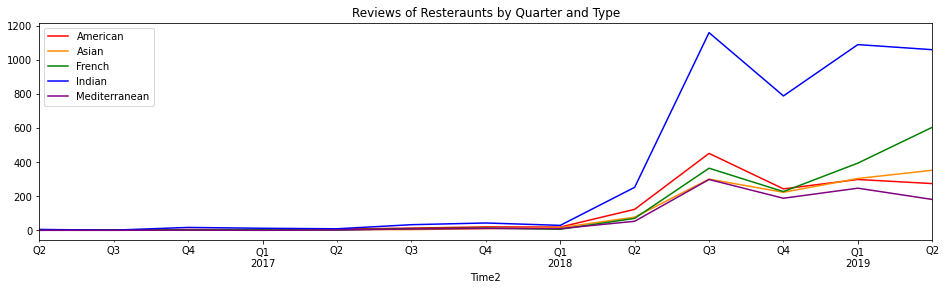

In [15]:
import matplotlib
plot_rules = dict(figsize=(16,4),color=['red', 'darkorange', 'green', 'blue', 'purple'],title='Reviews of Resteraunts by Quarter and Type')
quarterly_reviews.plot(**plot_rules)

### It seems as though there is a spike in reviews for all restaurants in Q3 of 2018, but especialy in Indian restaurants.  There also doesn't seem to be much data recorded at all from before 2018, although the increase in reviews from 2018 Q1 to Q3 seems gradual, so it's unlikely that this is entirely a case of an incomplete dataset.  More investigation would be required to find out what is really going on, and why there are so many more reviews for Indian restaurants compared to all other types of restaurant.